In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7' # Replace digit with number of desired GPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [2]:
# Basic Library Imports
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap, jit, grad, value_and_grad

from flax import linen as nn
import optax

from typing import Any, Callable, Sequence, Union
import matplotlib.pyplot as plt
import pandas as pd

import torch
import ml_collections

import time
import copy

import sys
sys.path.append('..') # makes modules in parent repository available to import

In [3]:
%autoreload 2
from archs import arch_from_config, ActNet, identity
from PoissonModel import PoissonModel
from utils import Poisson2DDataset

# w=32

In [4]:
# setup Poisson problem
w = 32
true_fun = lambda x, y : jnp.sin(jnp.pi*w*x)*jnp.sin(jnp.pi*w*y)
pde_res_fn = lambda x,y : -(jnp.pi**2) * (w**2 + w**2)*true_fun(x,y) # laplacian of true_fun
xx = jnp.linspace(-1,1, 128)
yy = jnp.linspace(-1,1, 128)
ins = jnp.meshgrid(xx, yy)
ins = [v.flatten()[:,None] for v in ins]
outs = true_fun(ins[0], ins[1])

In [5]:
# setup other training configurations
num_steps_adam = 30_000
num_steps_lbfgs = 100
seed = 2
batch_size = (5_000, 0)
normalize_inputs = True
pinn_weights = (0.001, 1.)
steps_per_check=500

In [6]:
# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = Poisson2DDataset(keys[0], batch_size=batch_size)
batch = next(iter(data_loader))

## ActNet

In [7]:
width = 137
depth=4
n_freq=8

# create config file for architecture
arch_config = ml_collections.ConfigDict()
arch_config.arch_type = 'ActNet'
arch_config.w0 = jnp.pi*w
arch_config.hyperparams = {
    'embed_dim' : width,
    'num_layers' : depth,
    'out_dim' : 1,
    'num_freqs' : n_freq,
    'output_activation' :  identity,
    'op_order' : 'A',
    # initializers 
    'freqs_init' : nn.initializers.normal(stddev=1.),
    'phases_init' : nn.initializers.zeros,
    'beta_init' : nn.initializers.variance_scaling(1., 'fan_in', distribution='uniform'),
    'lamb_init' : nn.initializers.variance_scaling(1., 'fan_in', distribution='uniform'),
    'act_bias_init' : nn.initializers.zeros,
    'proj_bias_init' : nn.initializers.zeros,
    'w0_init' : nn.initializers.constant(arch_config.w0),
    # other ActLayer configs
    'use_act_bias' : True,
    'freeze_basis' : False,
    'freq_scaling' : True,
    'freq_scaling_eps' : 1e-2,
    'precision' : 'highest',}

In [8]:
arch = arch_from_config(arch_config)

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.75, # decay_rate
    end_value=1e-7, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = PoissonModel(
    arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
    normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
    pde_res_fn = pde_res_fn, true_fun = true_fun,
    pinn_weights=pinn_weights)
print(f"w is {w : .2f}")
print(model.tabulate())

w is  32.00

                                      ActNet Summary                                      
┏━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path       ┃ module   ┃ inputs            ┃ outputs           ┃ params                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│            │ ActNet   │ float32[5000,2]   │ float32[5000,1]   │ w0: float32[]          │
│            │          │                   │                   │                        │
│            │          │                   │                   │ 1 (4 B)                │
├────────────┼──────────┼───────────────────┼───────────────────┼────────────────────────┤
│ Dense_0    │ Dense    │ float32[5000,2]   │ float32[5000,137] │ bias: float32[137]     │
│            │          │                   │                   │ kernel: float32[2,137] │
│            │          │                   │                   │            

In [9]:
# train adam
model.train(data_loader, nIter=num_steps_adam)

# train lbfgs
model.train_lbfgs(data_loader, nIter=num_steps_lbfgs)

# save a copy of the ActNet model
actnet_model = copy.deepcopy(model)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())
print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:13<00:00,  1.36it/s, loss: 9.394e-01, rel_l2: 4.76e-02, 'grad_norm': 1.53e+03]


Final loss is  9.39e-01 and relative L2 error is  4.80e-02


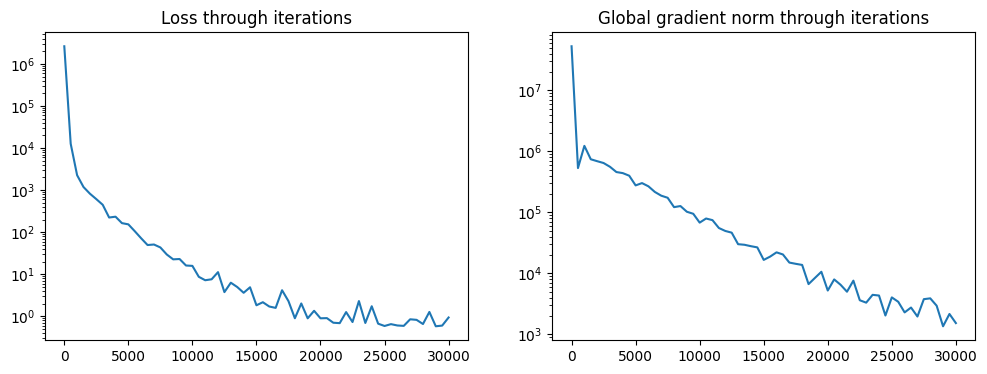

Relative L2 error: 4.80e-02
RMSE: 2.38e-02


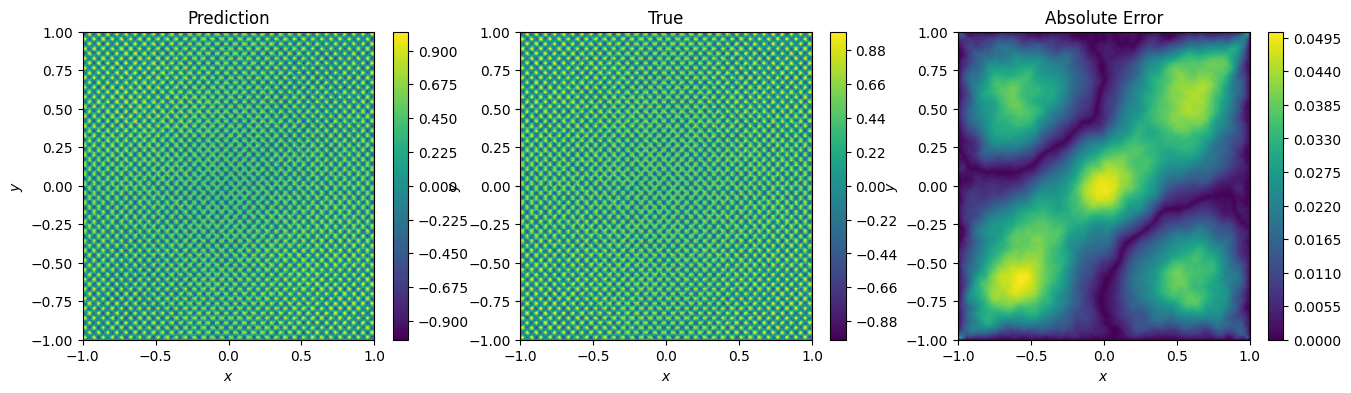

In [10]:
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

## Siren

In [11]:
# setup other training configurations
num_steps_adam = 30_000
num_steps_lbfgs = 100
seed = 0
batch_size = (5_000, 0)
normalize_inputs = True
pinn_weights = (0.001, 1.)
steps_per_check=500

# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = Poisson2DDataset(keys[0], batch_size=batch_size)
batch = next(iter(data_loader))

In [12]:
width = 200
depth = 2
w0_factor = 1/3

# create config file for architecture
arch_config = ml_collections.ConfigDict()
arch_config.arch_type = 'Siren'
arch_config.num_layers = depth
arch_config.embed_dim = width
arch_config.hyperparams = {
    'features' : [width] + depth*[width] + [1],
    'output_activation' :  identity,
    'w0' : jnp.pi*w*w0_factor,
    'precision' : 'highest',
    }

In [13]:
arch = arch_from_config(arch_config)

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.75, # decay_rate
    end_value=1e-7, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = PoissonModel(
    arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
    normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
    pde_res_fn = pde_res_fn, true_fun = true_fun,
    pinn_weights=pinn_weights)
print(f"w is {w : .2f}")
print(model.tabulate())

w is  32.00

                                     Siren Summary                                     
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Siren  │ float32[5000,2]   │ float32[5000,1]   │                          │
├─────────┼────────┼───────────────────┼───────────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[5000,2]   │ float32[5000,200] │ bias: float32[200]       │
│         │        │                   │                   │ kernel: float32[2,200]   │
│         │        │                   │                   │                          │
│         │        │                   │                   │ 600 (2.4 KB)             │
├─────────┼────────┼───────────────────┼───────────────────┼──────────────────────────┤
│ Dense_1 │ Dense  

In [14]:
# train adam
model.train(data_loader, nIter=num_steps_adam)

# train lbfgs
model.train_lbfgs(data_loader, nIter=num_steps_lbfgs)

# save a copy of the Siren model
siren_model = copy.deepcopy(model)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())
print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  6.99it/s, loss: 1.432e+02, rel_l2: 1.94e-01, 'grad_norm': 3.02e+03]


Final loss is  1.43e+02 and relative L2 error is  1.91e-01


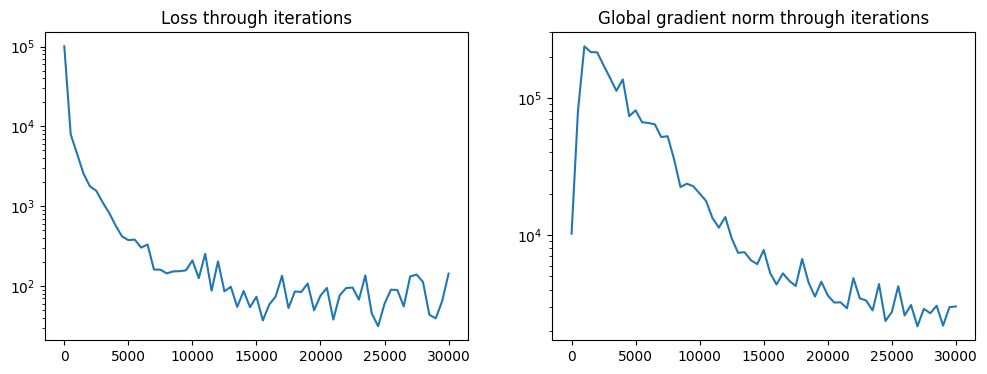

Relative L2 error: 1.91e-01
RMSE: 9.48e-02


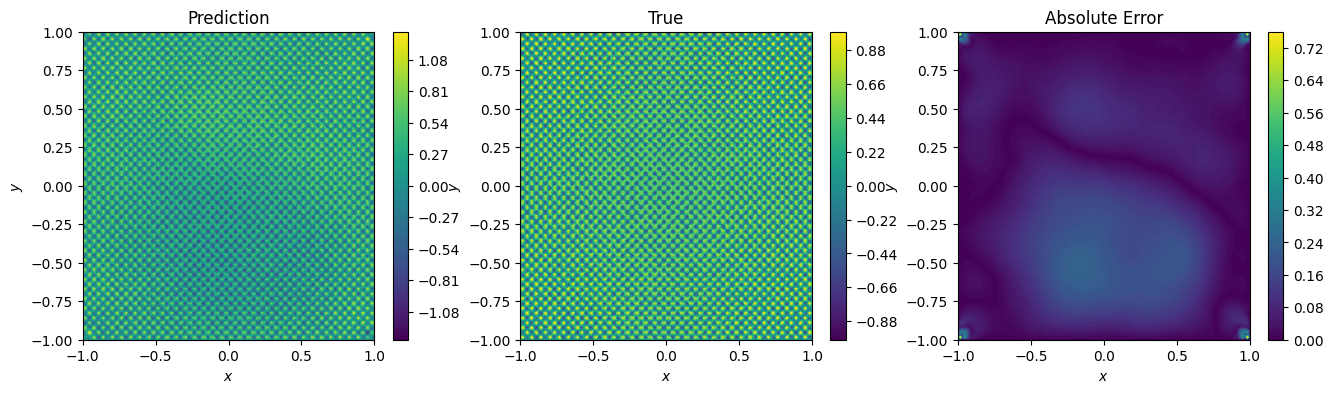

In [15]:
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

## Plotting both ActNet & Siren

In [16]:
# higher resolution grid for plotting
# also slightly remove corners to better visualize residuals in the interior of the domain
xx = jnp.linspace(-.95,.95, 256)
yy = jnp.linspace(-.95,.95, 256)
ins = jnp.meshgrid(xx, yy)
ins = [v.flatten()[:,None] for v in ins]
outs = true_fun(ins[0], ins[1])

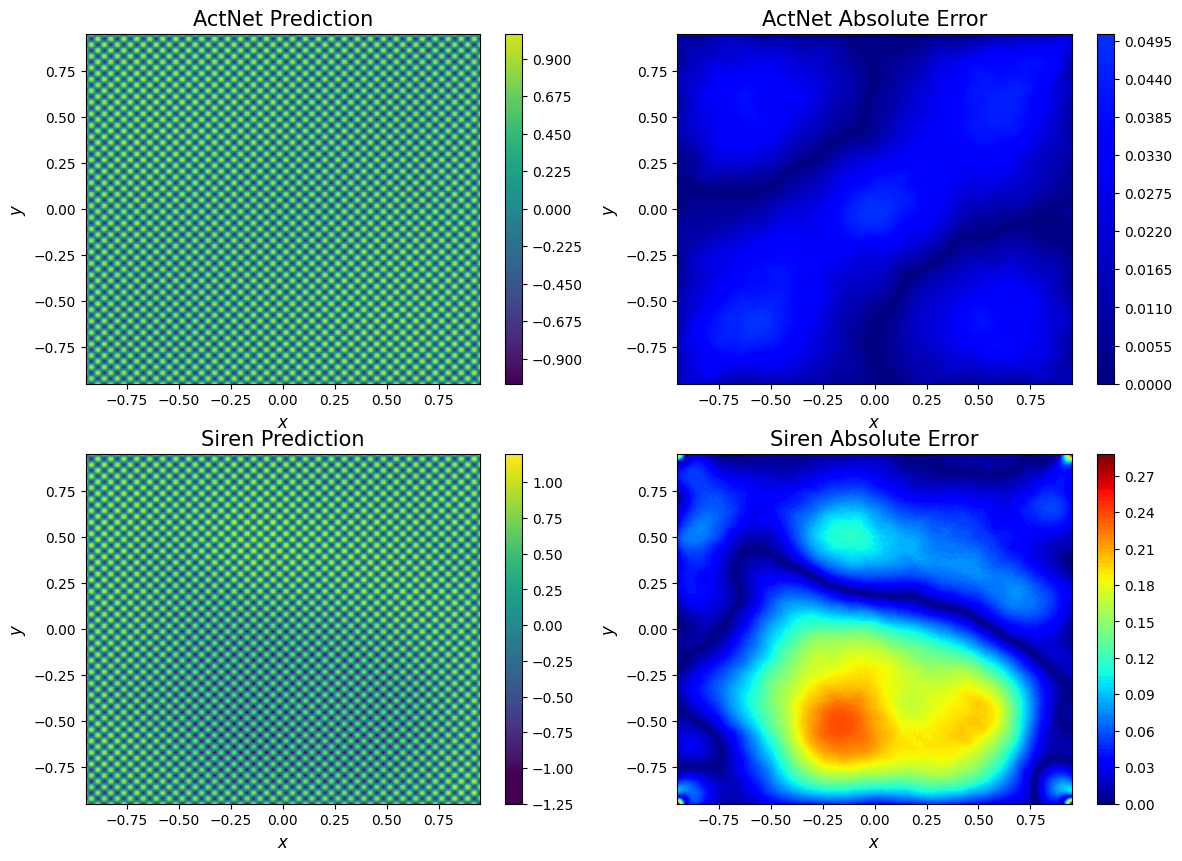

In [17]:
plt.figure(figsize=(14, 10))
u, s_true = jnp.hstack(ins), outs
title_size=15
axis_size=12

# Create predictions for actnet
s_pred_actnet = actnet_model.batched_apply(u, batch_size=2_048)
error_actnet = abs(s_pred_actnet - s_true)
# Create predictions for Siren
s_pred_siren = siren_model.batched_apply(u, batch_size=2_048)
error_siren = abs(s_pred_siren - s_true)

vmax_pred = max(s_pred_actnet.max(), s_pred_siren.max())
vmin_pred = max(s_pred_actnet.min(), s_pred_siren.min())
vmax = max(error_actnet.max(), error_siren.max())

### ActNet
# Ploting examples of reconstructions
plt.subplot(221)
plt.tricontourf(u[:,0], u[:,1], s_pred_actnet.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(222)
plt.tricontourf(u[:,0], u[:,1], error_actnet.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Absolute Error', fontsize=title_size)

### Siren
# Ploting examples of reconstructions
plt.subplot(223)
plt.tricontourf(u[:,0], u[:,1], s_pred_siren.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(224)
plt.tricontourf(u[:,0], u[:,1], error_siren.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Absolute Error', fontsize=title_size)

plt.savefig('Poisson32_predictions.png', bbox_inches='tight', dpi=300)

plt.show()

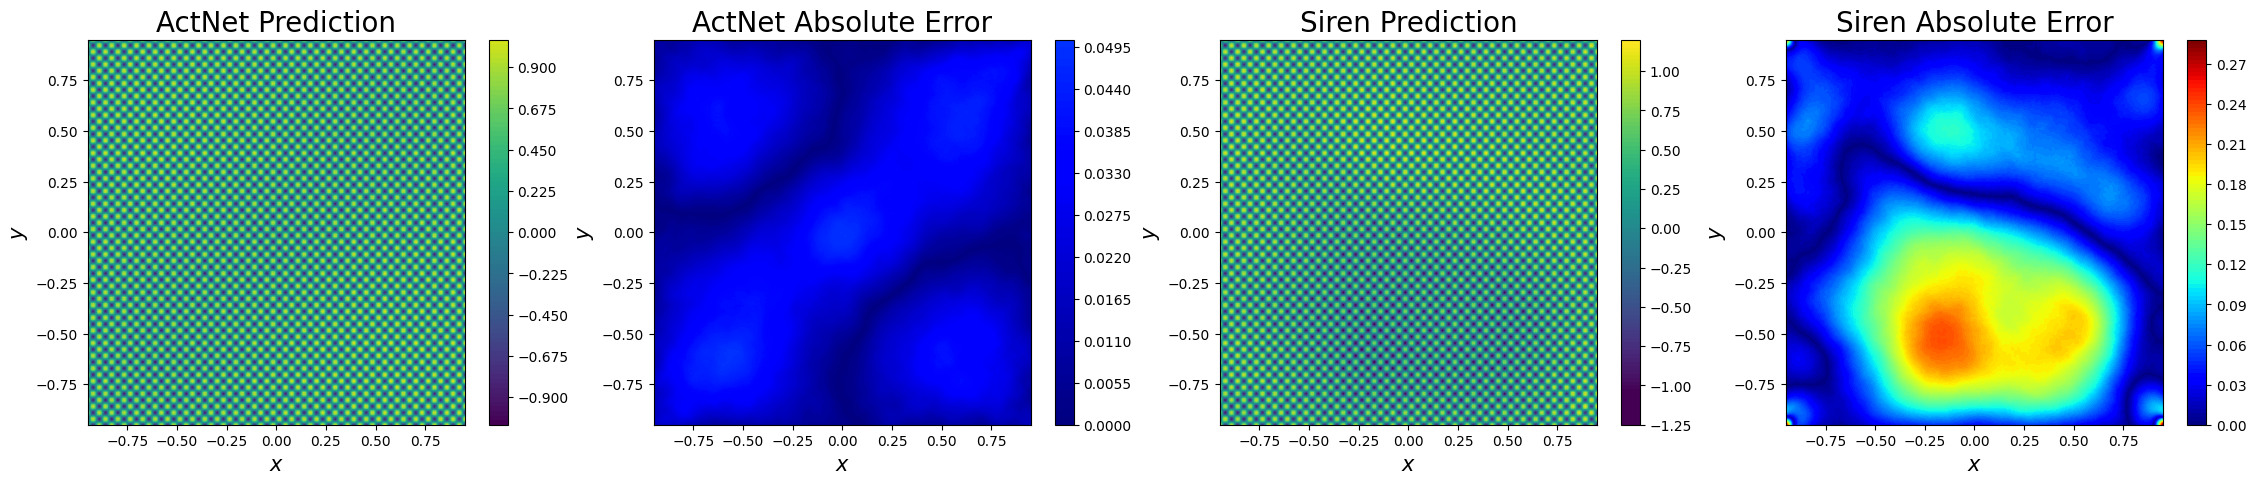

In [18]:
plt.figure(figsize=(28, 5))
u, s_true = jnp.hstack(ins), outs
title_size=20
axis_size=15

# Create predictions for actnet
s_pred_actnet = actnet_model.batched_apply(u, batch_size=2_048)
error_actnet = abs(s_pred_actnet - s_true)
# Create predictions for Siren
s_pred_siren = siren_model.batched_apply(u, batch_size=2_048)
error_siren = abs(s_pred_siren - s_true)

vmax_pred = max(s_pred_actnet.max(), s_pred_siren.max())
vmin_pred = max(s_pred_actnet.min(), s_pred_siren.min())
vmax = max(error_actnet.max(), error_siren.max())

### ActNet
# Ploting examples of reconstructions
plt.subplot(141)
plt.tricontourf(u[:,0], u[:,1], s_pred_actnet.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(142)
plt.tricontourf(u[:,0], u[:,1], error_actnet.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('ActNet Absolute Error', fontsize=title_size)

### Siren
# Ploting examples of reconstructions
plt.subplot(143)
plt.tricontourf(u[:,0], u[:,1], s_pred_siren.squeeze(), levels=100, vmax=vmax_pred, vmin=vmin_pred)
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Prediction', fontsize=title_size)
# Ploting absolute error
plt.subplot(144)
plt.tricontourf(u[:,0], u[:,1], error_siren.squeeze(), levels=100, vmax=vmax, cmap='jet')
plt.colorbar()
plt.xlabel('$x$', fontsize=axis_size)
plt.ylabel('$y$', fontsize=axis_size)
plt.title('Siren Absolute Error', fontsize=title_size)

plt.savefig('Poisson32_predictions_horizontal.png', bbox_inches='tight', dpi=300)

plt.show()